cuda


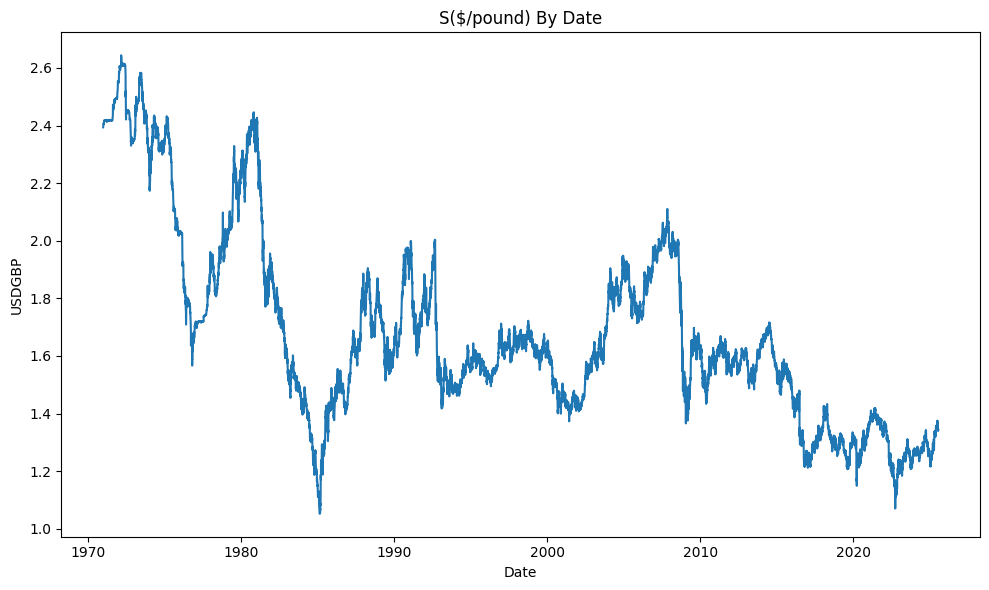

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import mlflow
import mlflow.pytorch


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)



usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDGBP',data=df)
plt.title("S($/pound) By Date")
plt.savefig("images/spotrate.png")
plt.tight_layout()
plt.show()


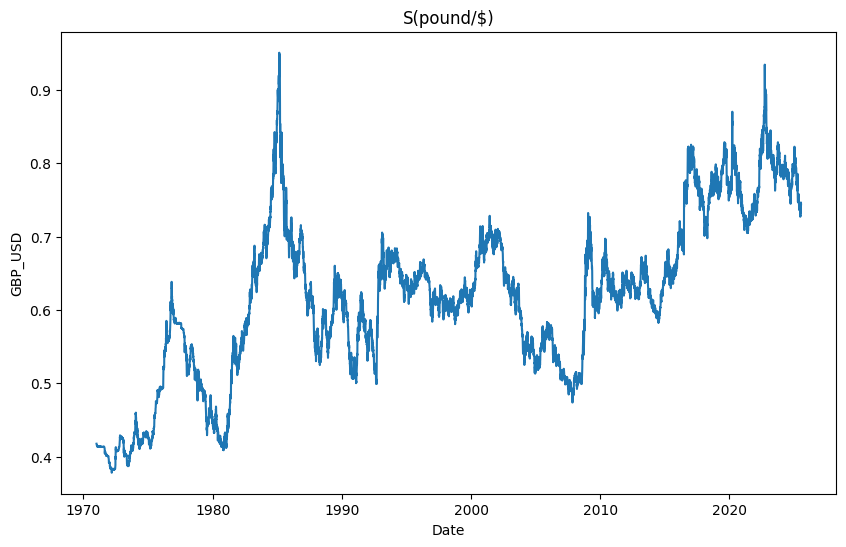

In [2]:
df1 = df.copy()
df1['GBP_USD'] = 1 / df['USDGBP']

plt.figure(figsize=(10,6))
sns.lineplot(x=df1['Date'],y=df1['GBP_USD'])
plt.title("S(pound/$)")
plt.savefig("images/sportrate_GBPUSD")
plt.show()

In [3]:
GBP_USD = 1  / df['USDGBP']

USD_GBP = 1 / GBP_USD

A = np.array([[USD_GBP,GBP_USD],[GBP_USD,USD_GBP]])

print(f'1:1 Parity of of Exchange Rates: {A.T}')

1:1 Parity of of Exchange Rates: [[[2.3938     0.41774584]
  [0.41774584 2.3938    ]]

 [[2.3949     0.41755397]
  [0.41755397 2.3949    ]]

 [[2.3967     0.41724037]
  [0.41724037 2.3967    ]]

 ...

 [[1.3426     0.74482348]
  [0.74482348 1.3426    ]]

 [[1.3413     0.74554537]
  [0.74554537 1.3413    ]]

 [[1.3439     0.74410298]
  [0.74410298 1.3439    ]]]


In [4]:
df1 = df.copy()


df1.dropna(inplace=True)

df_train = df1.iloc[:,0:1].values



train_size = int(len(df_train) * .90)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length - 1):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 4

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()






class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out


input_size = 1
hidden_size = 256
num_layers = 256
num_layers = 1
output_size = 1

gru_model = GRU(input_size,hidden_size,num_layers,output_size)
epochs = 500
learning_rate = 0.001
optimizer_gru = torch.optim.Adam(params=gru_model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()


In [5]:
with mlflow.start_run() as run:

    mlflow.log_params({
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "epochs": epochs,
        "learning_rate": learning_rate,
        "optimizer": optimizer_gru.__class__.__name__,
        "loss_function": loss_fn.__class__.__name__
    }) 

    for epoch in range(epochs):
        y_pred = gru_model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        optimizer_gru.zero_grad()
        loss.backward()
        optimizer_gru.step()

        if epoch % 1 != 0:
            continue

        gru_model.eval()
        with torch.no_grad():
            y_pred_train = gru_model(X_train)
            train_rsme = np.sqrt(loss_fn(y_pred_train, y_train))
            y_pred_test = gru_model(X_test)
            test_rsme = np.sqrt(loss_fn(y_pred_test, y_test))
            print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

         
            mlflow.log_metric("train_rsme", train_rsme, step=epoch) 
            mlflow.log_metric("test_rsme", test_rsme, step=epoch) 


    mlflow.pytorch.log_model(pytorch_model=gru_model, artifact_path="gru_model")

C:\Users\katsa\AppData\Local\Temp\ipykernel_6848\237286656.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred_train, y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_6848\237286656.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test, y_test))


Epoch: 0; train_RSEM: 0.413; Test RSME: 0.1034
Epoch: 1; train_RSEM: 0.365; Test RSME: 0.06239
Epoch: 2; train_RSEM: 0.3173; Test RSME: 0.03767
Epoch: 3; train_RSEM: 0.2704; Test RSME: 0.06098
Epoch: 4; train_RSEM: 0.226; Test RSME: 0.1071
Epoch: 5; train_RSEM: 0.1882; Test RSME: 0.1596
Epoch: 6; train_RSEM: 0.1656; Test RSME: 0.2152
Epoch: 7; train_RSEM: 0.1665; Test RSME: 0.2699
Epoch: 8; train_RSEM: 0.1855; Test RSME: 0.3162
Epoch: 9; train_RSEM: 0.2045; Test RSME: 0.345
Epoch: 10; train_RSEM: 0.2117; Test RSME: 0.3537
Epoch: 11; train_RSEM: 0.2064; Test RSME: 0.3457
Epoch: 12; train_RSEM: 0.1927; Test RSME: 0.3262
Epoch: 13; train_RSEM: 0.176; Test RSME: 0.3001
Epoch: 14; train_RSEM: 0.1609; Test RSME: 0.2714
Epoch: 15; train_RSEM: 0.1505; Test RSME: 0.2427
Epoch: 16; train_RSEM: 0.1459; Test RSME: 0.2161
Epoch: 17; train_RSEM: 0.1458; Test RSME: 0.1927
Epoch: 18; train_RSEM: 0.1484; Test RSME: 0.1731
Epoch: 19; train_RSEM: 0.1516; Test RSME: 0.1577
Epoch: 20; train_RSEM: 0.1538; T

2025/07/23 22:12:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch: 499; train_RSEM: 0.009338; Test RSME: 0.006808


2025/07/23 22:12:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/23 22:12:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/23 22:12:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


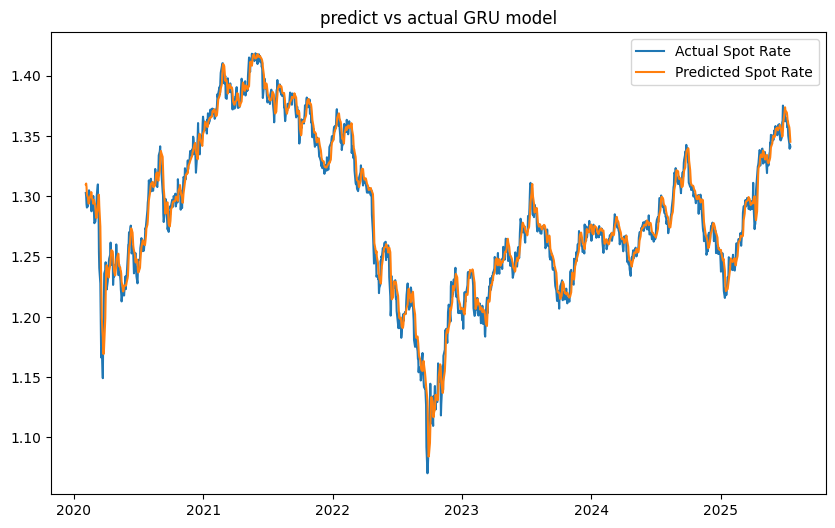

In [8]:
with torch.no_grad():
    pred = gru_model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df1.iloc[train_size + seq_length: -1]['Date']


gru_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(gru_comparison_df['Date'],gru_comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(gru_comparison_df['Date'],gru_comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predict vs actual GRU model")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate_gru.png")
plt.show()


In [9]:
print(np.round(gru_comparison_df,4).head(20))
print(np.round(gru_comparison_df,4).tail(20))

            Date  Actual Spot Rate  Predicted Spot Rate
12314 2020-02-04            1.3029               1.3100
12315 2020-02-05            1.3000               1.3107
12316 2020-02-06            1.2935               1.3079
12317 2020-02-07            1.2908               1.3014
12318 2020-02-10            1.2919               1.2991
12319 2020-02-11            1.2945               1.2959
12320 2020-02-12            1.2978               1.2940
12321 2020-02-13            1.3051               1.2948
12322 2020-02-14            1.3039               1.2979
12323 2020-02-18            1.3017               1.3012
12324 2020-02-19            1.2934               1.3036
12325 2020-02-20            1.2877               1.3034
12326 2020-02-21            1.2966               1.2994
12327 2020-02-24            1.2923               1.2963
12328 2020-02-25            1.3004               1.2939
12329 2020-02-26            1.2921               1.2951
12330 2020-02-27            1.2876              